<a href="https://colab.research.google.com/github/sayan0506/Task-2-Internship/blob/main/IIITD_assignment_task_2_test_script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Training Central Dataset**

Assignment link: 

https://docs.google.com/document/d/1WQHJ2KpImvA1l5QOkLQjaECOSKMiT3jp_UKH2p1zk_c/edit

In [1]:
# install keras livelossplot
!pip -q install livelossplot

# install wandb
!pip install --upgrade wandb

Requirement already up-to-date: wandb in /usr/local/lib/python3.7/dist-packages (0.10.24)


# **Import Modules**

In [2]:
import zipfile
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pandas as pd

import tensorflow as tf
from keras.preprocessing.image import img_to_array

# **Environment Setup**
**Improve Reproducibility**

In [3]:
# improve reproducibility and make it more deterministic
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
tf.random.set_seed(hash("by rmoving stochasticity")% 2**32 -1)

**Setup wandb environment**

In [4]:
import wandb
from wandb.keras import WandbCallback

# authorize
# wandb.login()

# **Download and unzipping the Dataset**

[Dropbox dataset link](https://www.dropbox.com/s/pan6mutc5xj5kj0/trainPart1.zip)

In [5]:
!wget https://www.dropbox.com/s/pan6mutc5xj5kj0/trainPart1.zip

--2021-04-05 22:52:05--  https://www.dropbox.com/s/pan6mutc5xj5kj0/trainPart1.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:601a:18::a27d:712
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/pan6mutc5xj5kj0/trainPart1.zip [following]
--2021-04-05 22:52:06--  https://www.dropbox.com/s/raw/pan6mutc5xj5kj0/trainPart1.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc64bc3de92bcc30a9fa2c303b4d.dl.dropboxusercontent.com/cd/0/inline/BMF1ugvB2EmlB_30PM89AmrRiImug5dQmtonS0aAAZFeFz8BwTRu-lAmgSgvqNpYkkQlp36hY15DudVBX71Rs8v6ycJPcw3TC8rVcqbJj-l0o5bG-b5HUD2pBFN0qnkA5WAs-rsHBI2bwln79Gzn3DZ5/file# [following]
--2021-04-05 22:52:06--  https://uc64bc3de92bcc30a9fa2c303b4d.dl.dropboxusercontent.com/cd/0/inline/BMF1ugvB2EmlB_30PM89AmrRiImug5dQmtonS0aAAZFeFz8BwTRu-lAmgSgvqNpYkkQlp36hY15DudVBX71R

## Unzipping

In [6]:
# defining unzipping function
def unzip(zip_file, content_dir):
  if not os.path.isdir(content_dir):
    os.mkdir(content_dir)

  # unzipping
  with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(content_dir)

In [7]:
# zipfile path
zip_file = '/content/trainPart1.zip'

# content directory
content_dir = 'master_data'

# calling unzip
unzip(zip_file, content_dir)

# **Data Inspection**

In [8]:
# master directory path
img_dir = '/content/master_data/train'

# classifiers list
print(f'List of classifiers\n{sorted(os.listdir(img_dir))}')
print(f'Total {len(os.listdir(img_dir))} classifiers are there')


List of classifiers
['Sample001', 'Sample002', 'Sample003', 'Sample004', 'Sample005', 'Sample006', 'Sample007', 'Sample008', 'Sample009', 'Sample010', 'Sample011', 'Sample012', 'Sample013', 'Sample014', 'Sample015', 'Sample016', 'Sample017', 'Sample018', 'Sample019', 'Sample020', 'Sample021', 'Sample022', 'Sample023', 'Sample024', 'Sample025', 'Sample026', 'Sample027', 'Sample028', 'Sample029', 'Sample030', 'Sample031', 'Sample032', 'Sample033', 'Sample034', 'Sample035', 'Sample036', 'Sample037', 'Sample038', 'Sample039', 'Sample040', 'Sample041', 'Sample042', 'Sample043', 'Sample044', 'Sample045', 'Sample046', 'Sample047', 'Sample048', 'Sample049', 'Sample050', 'Sample051', 'Sample052', 'Sample053', 'Sample054', 'Sample055', 'Sample056', 'Sample057', 'Sample058', 'Sample059', 'Sample060', 'Sample061', 'Sample062']
Total 62 classifiers are there


## Defining the classifiers

From the dataset we are adding custom labels to the classifiers. We find that each of the individual folder consist of unique classes.

In [9]:
class_ids = [int(id.split('Sample')[1]) for id in sorted(os.listdir(img_dir))]
print(f'We are representing the {len(class_ids)} class ids with the following ids respectively, also for prediction')
for cls in class_ids: print(cls)

We are representing the 62 class ids with the following ids respectively, also for prediction
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62


## Data Visualization

 Defining the function to visualize random sample from each image class

In [10]:
def vis_images(img_dir, class_ids):
  '''
  Visualizing random samples for each class
  '''
  # no of image in each row
  cols = 9
  rows = int(np.ceil(len(os.listdir(img_dir))/cols))
  # samples left for the last row, the remainders
  end_count = len(os.listdir(img_dir))%cols
  
  # defining the figure to visualize
  fig = plt.figure(figsize = (30,25))
  fig.suptitle('Visualize samples from individual classes', fontsize = 16)
  fig.tight_layout()
  fig.subplots_adjust(top = 0.95)
  
  for id, folder in enumerate(sorted(os.listdir(img_dir))):

    # fetching random image sample
    id_path = os.path.join(img_dir,folder)
    img_sample = random.choice(os.listdir(id_path))
    img_path = os.path.join(id_path, img_sample)
    img = plt.imread(img_path)

    # visualize
    fig.add_subplot(rows, cols, id+1)
    plt.imshow(img)
    plt.xlabel(f'Class id: {class_ids[id]}')
    
  plt.show()


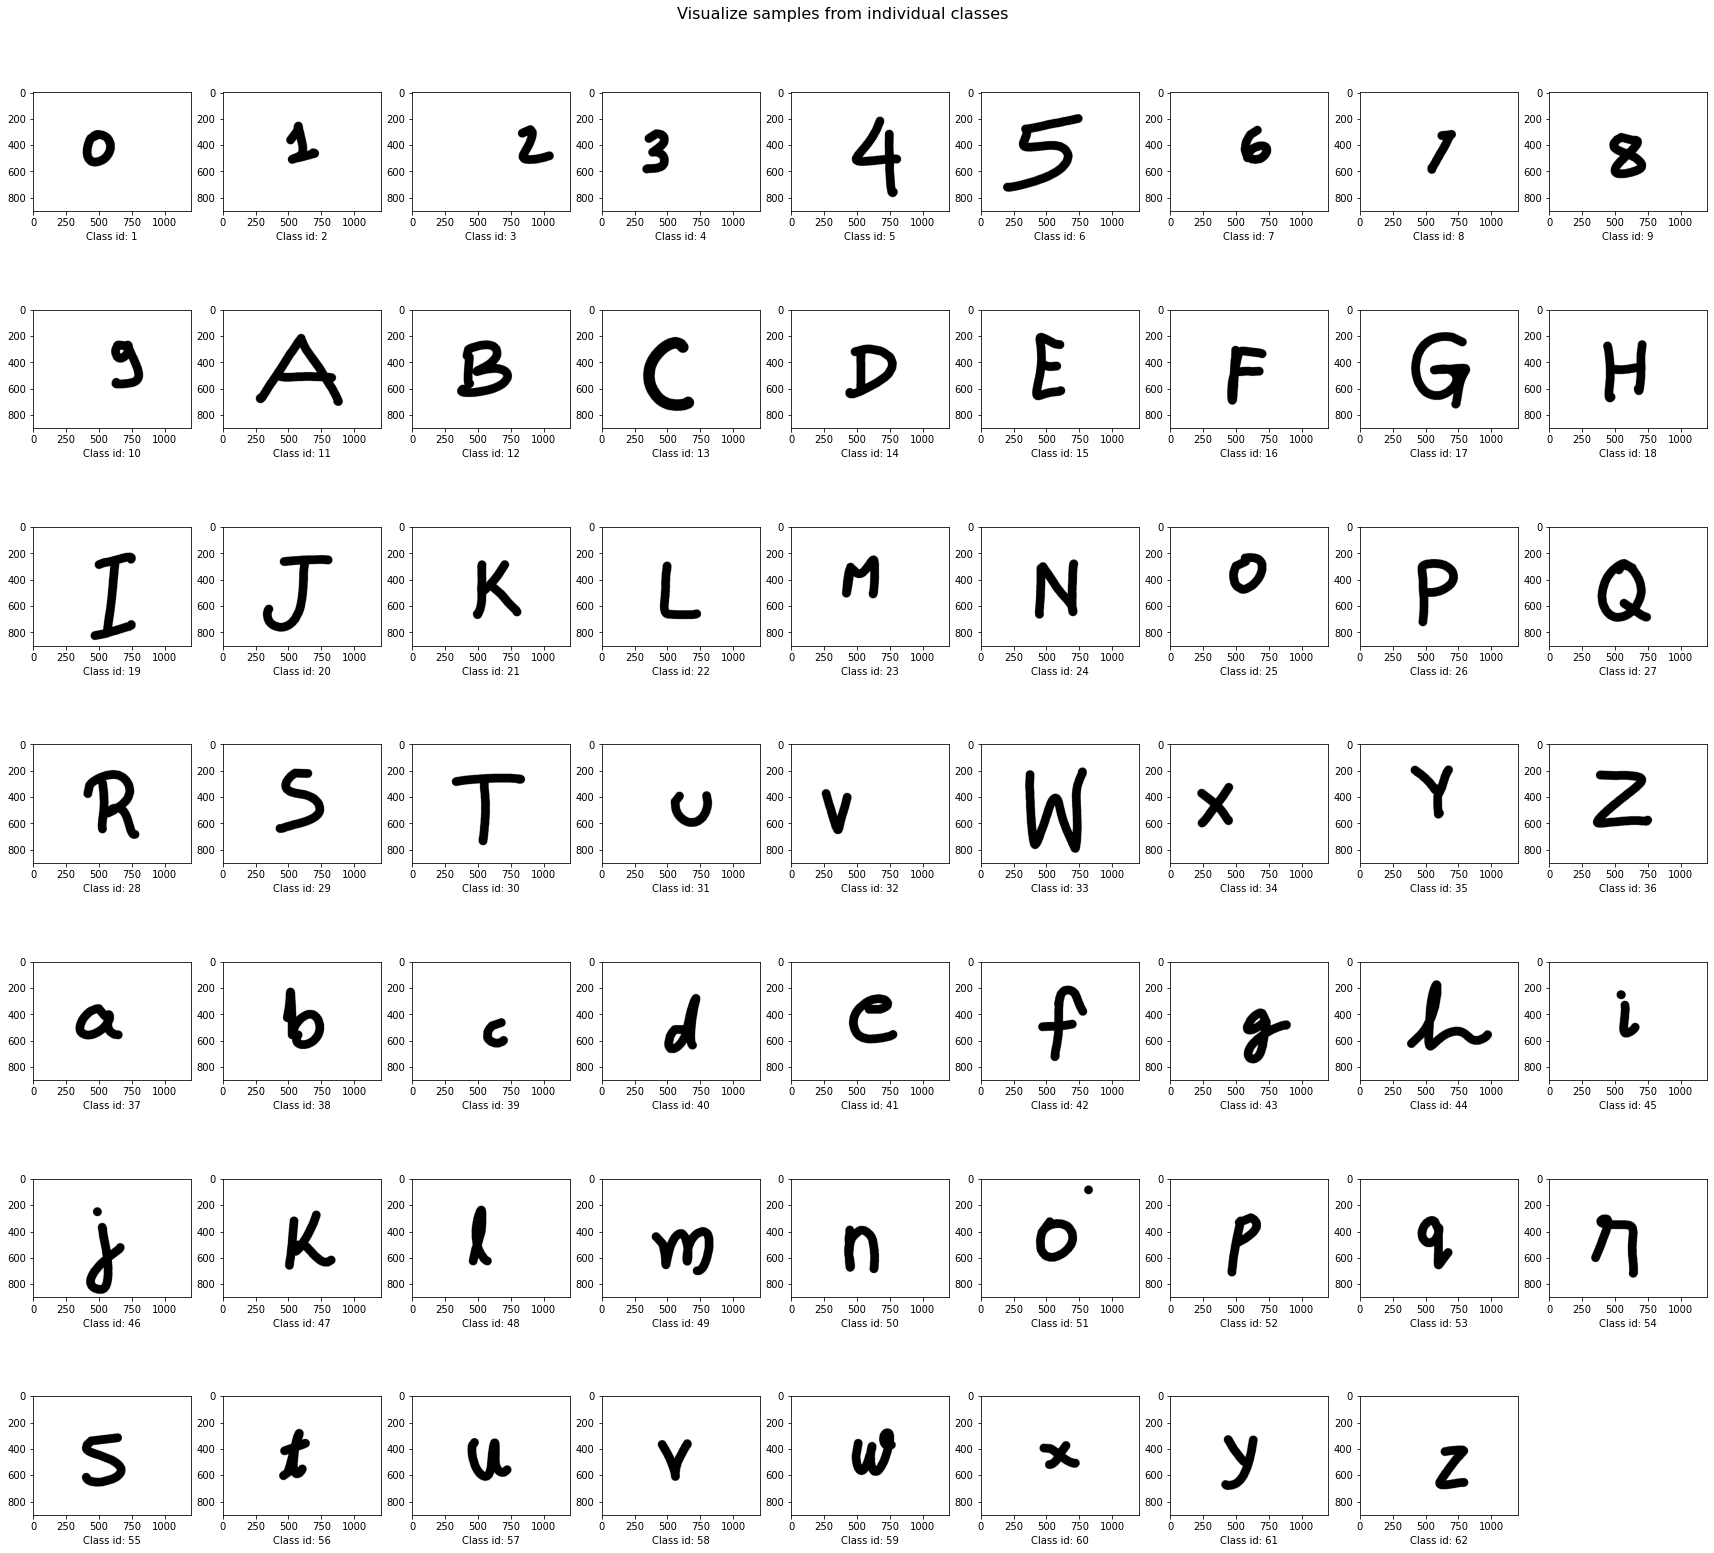

In [11]:
vis_images(img_dir, class_ids)

## Data Loading

Function for image to array conversion using keras

In [12]:
def convert_img_to_array(image_path):
  try:
    img = plt.imread(image_path)
    if img is not None:
      return img_to_array(img)
    else:
      return np.array([])

  except Exception as e:
    print(f'Error  {e}')
    return None

Defining function for creating image array and labels list from the folder

In [13]:
def fetch_img(img_dir):
  samples_list = sorted(os.listdir(img_dir))
  classifiers_path = [os.path.join(img_dir, path) for path in sorted(os.listdir(img_dir))]
  print(f'Classifiers directory names {classifiers_path}')
  # image array list
  image_list = []
  # image labels list
  label_list = []
  # label dataframe
  label_df = pd.DataFrame(columns = sorted(os.listdir(img_dir)))
  # image dataframe
  img_df = pd.DataFrame(columns = ['Image', 'Shape', 'Label'])
  try:
    print('\n[INFO] Loading images ...')
    # total sample count
    sample_count = 0
    for sr, c_path in enumerate(classifiers_path):
      print(f'[INFO] Processing {samples_list[sr]}')
      path_list = os.listdir(c_path)
      # removing .DS_store files from list if present
      for cs in path_list:
        if cs == '.DS_store':
          path_list.remove(cs)
      
      # categorical count
      count = 0
      for class_sample in path_list:
        class_sample_path = os.path.join(c_path, class_sample)
        if class_sample_path.endswith(".jpg")==True or class_sample_path.endswith(".JPG")==True or class_sample_path.endswith(".png")==True:
          img = convert_img_to_array(class_sample_path)
          image_list.append(img)
          label_list.append(class_ids[sr])
          #img_df.loc[sample_count, 'Image'], img_df[sample_count, 'Label'] = class_sample, class_ids[sr]
          #img_df.loc[sample_count, 'Shape'] = img.shape
          count += 1
          sample_count += 1
      #label_df.loc[0, samples_list[sr]] = count

    return image_list, label_list, label_df, img_df

  except Exception as e:
    print(f'Error {e}')
    return None 

In [14]:
fetch_img(img_dir)

Classifiers directory names ['/content/master_data/train/Sample001', '/content/master_data/train/Sample002', '/content/master_data/train/Sample003', '/content/master_data/train/Sample004', '/content/master_data/train/Sample005', '/content/master_data/train/Sample006', '/content/master_data/train/Sample007', '/content/master_data/train/Sample008', '/content/master_data/train/Sample009', '/content/master_data/train/Sample010', '/content/master_data/train/Sample011', '/content/master_data/train/Sample012', '/content/master_data/train/Sample013', '/content/master_data/train/Sample014', '/content/master_data/train/Sample015', '/content/master_data/train/Sample016', '/content/master_data/train/Sample017', '/content/master_data/train/Sample018', '/content/master_data/train/Sample019', '/content/master_data/train/Sample020', '/content/master_data/train/Sample021', '/content/master_data/train/Sample022', '/content/master_data/train/Sample023', '/content/master_data/train/Sample024', '/content/m

KeyboardInterrupt: ignored